In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell
from utils import Kb,Epsilon_unit,Argon_mass,Sigma_unit
import os
import random
import pandas as pd
import math
import numba
import numba as nb
import time
from tqdm import tqdm
from utils import read_txt_file,write_xyz_file
import MDAnalysis as mda

/home/hongshuh/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# RHM

Markov Chain

eigenvector $\pi$, row vector p we have $p\pi = p$


$$\pi_{mn}$$

$a_{mn}$ if $p_n >= p_m$,

$a_{mn}\frac{p_n}{p_m}$ if $p_n < p_m$,

$1 - \sum_{m\neq n}\pi_{mn}$ if $m=n$

In [12]:
# Define the path to the .dat file
file_path = './hw5/three-timesteps-of-velocities.dat'

# Open the file for reading
with open(file_path, 'r') as file:
    # Read the lines in the file
    lines = file.readlines()
    # print(lines)
    # Find where the data starts in the file (depends on LAMMPS file format)
    start_index_list = []
    for i,line in enumerate(lines):
        if "ITEM: ATOMS" in line:
            start_index_list.append(i+1)
    # start_index = next(i for i, line in enumerate(lines) if "ITEM: ATOMS" in line) + 1

    # Initialize an empty list to store velocity data
    vel_list = []
    for idx in start_index_list:
        vel_idx = []
        for line in lines[idx:]:
            if "ITEM:" in line:
                break  # Stop if we've reached a new section
            data = line.strip().split()
            # Assuming that velocities are in columns 2, 3, and 4
            vx, vy, vz = map(float, data[1:4])
            vel_idx.append((vx, vy, vz))
        vel_list.append(vel_idx)
   


In [13]:
vel_array = np.array(vel_list)
vel_array.shape

(3, 1372, 3)

In [ ]:
vel1

In [28]:
vacf = 0.0
for i in range(len(vel_array[0])):
    vacf += np.dot(vel_array[0][i],vel_array[2][i])
    # break
vacf/1372

3.724897187332624

In [37]:
with open('./hw5/vacf-and-msd-PS5.dat.txt','r') as f:
    lines = f.readlines()
msd_array = []
vacf_array = []
for i,line in enumerate(lines):
    if i == 0:
        continue
    else:
        data = line.strip().split()
        vacf,msd = map(float,data)
        msd_array.append(msd)
        vacf_array.append(vacf)

    # print(data)
    # break

In [41]:
msd_array = np.array(msd_array)
vacf_array = np.array(vacf_array)
msd_array.shape

(801,)

In [42]:
vacf_array[1:-1].shape

(799,)

In [43]:
D = 0.0
D = 1/3 * 0.005 * (vacf_array[0] + 2 * vacf_array[1:-1].sum() + vacf_array[-1]) / 2
D

0.06814416666666666

Text(0, 0.5, 'MSD')

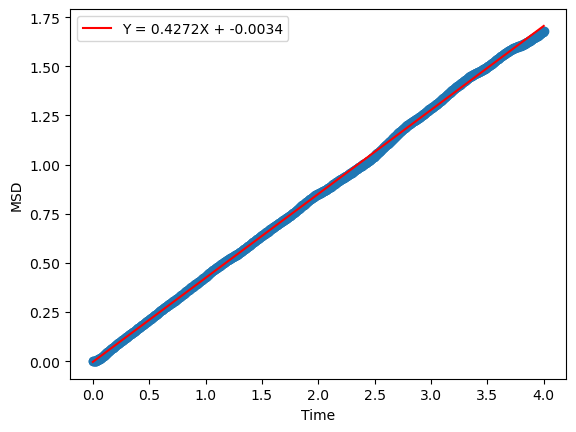

In [47]:
from scipy.stats import linregress

x = np.arange(len(msd_array))*0.005
result = linregress(x,msd_array)
k = result.slope
b = result.intercept
plt.scatter(x,msd_array)
plt.plot(x,k*x+b,'r',label = f'Y = {np.round(k,4)}X + {np.round(b,4)}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MSD')

In [48]:
k/6

0.07120416522675832

In [1]:
def energy(x):
    return x**2/2

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
k = 1  # Force constant for the harmonic oscillator

beta = 0.1  # Inverse temperature

# Monte Carlo simulation of a harmonic oscillator
def mc_hc(n_steps, x0, delta):
    x = x0
    samples = []
    
    # Potential energy of a harmonic oscillator
    V = lambda x: 0.5 * k * x**2
    
    for step in range(n_steps):
        # Propose a move
        x_new = x + random.choice([-delta, delta])
        
        # Calculate energy change
        delta_E = V(x_new) - V(x)
        
        #criterion
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            x = x_new
        
        samples.append(x)
    
    return np.array(samples)

# Parameters
n_steps = 10000000  # Number of Monte Carlo steps
x0 = 100  # Starting position
delta = 1  # Maximum displacement per step

# Run simulation
samples = mc_hc(n_steps, x0, delta)
# Result
print(f'Averge position {np.round(np.mean(samples),4)}')
print(f'Averge x^2 {np.round(np.mean(samples**2),4)}')
print(f'Averge U {np.round(np.mean(samples**2/2),4)}')



Averge position 0.0077
Averge x^2 10.0645
Averge U 5.0323


In [2]:
def two_level_two_particle(n_steps = 100000,beta = 0.01):
    e1 = 0.0
    e2 = 1.0
    def U (x,y):
        return x + y + x * y

    u1 = 0.0
    u2 = 0.0
    samples = []

    for i in tqdm(range(n_steps)):
        u1_new = random.choice([e1,e2])
        u2_new = random.choice([e1,e2])
        delta_E = U(u1_new,u2_new) - U(u1,u2)
        if delta_E <= 0 or np.random.rand() < np.exp(-beta * delta_E):
            u1,u2 = u1_new,u2_new
        samples.append(U(u1,u2))
    # samples = np.array(samples)
    return samples

samples =two_level_two_particle()
print(f'Averge U {np.round(np.mean(samples),4)}')


100%|██████████| 100000/100000 [00:00<00:00, 544372.63it/s]

Averge U 1.236


In [98]:
samples = two_level_two_particle(beta=10.0)
np.mean(samples)

100%|██████████| 1000000/1000000 [00:02<00:00, 423502.33it/s]


9.6e-05

In [3]:
betalist = 10 ** np.arange(-2,2.1,0.1)
U_list = []
for beta in tqdm(betalist):
    U_list.append(np.mean(two_level_two_particle(beta=beta)))

100%|██████████| 41/41 [00:09<00:00,  4.24it/s]


Text(0, 0.5, 'Probability to higher energy state')

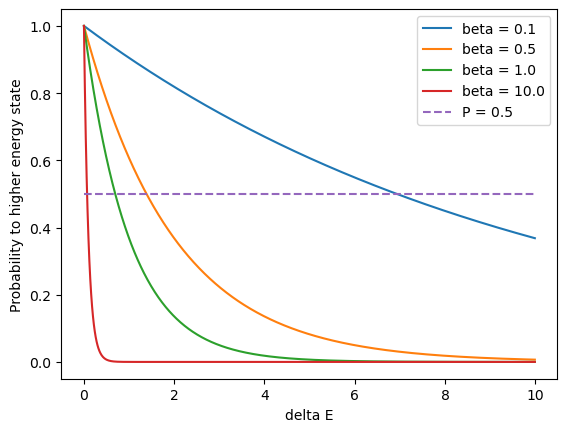

In [11]:
deltaE = np.arange(0,10,0.01)
for beta in [0.1,0.5,1.0,10.0]:
    plt.plot(deltaE,np.exp(-beta*deltaE),label=f'beta = {beta}')
plt.plot(deltaE,np.ones(deltaE.shape)/2,'--',label='P = 0.5')
plt.legend()
plt.xlabel('delta E')
plt.ylabel('Probability to higher energy state')

Text(0, 0.5, 'U')

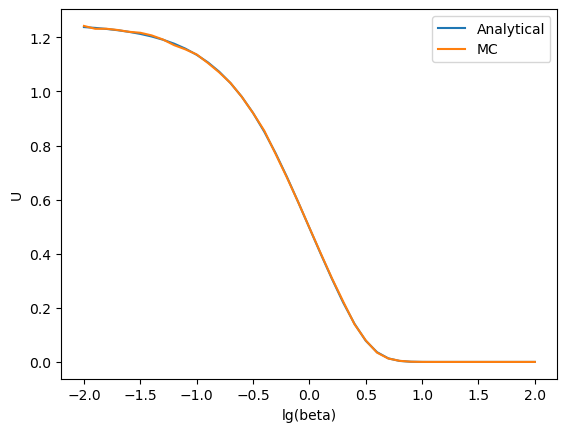

In [46]:
exp_U = (2*np.exp(-betalist) +3*np.exp(-3*betalist))/ (1 + 2*np.exp(-betalist) +np.exp(-3*betalist) )
plt.plot(np.log10(betalist),exp_U,label='Analytical')
plt.plot(np.log10(betalist),U_list,label='MC')
plt.legend()
plt.xlabel('lg(beta)')
plt.ylabel('U')

In [47]:
5/4

1.25